# Pink Noise Is All You Need: Colored Noise Exploration in Deep Reinforcement Learning
  https://openreview.net/forum?id=hQ9V5QN27eS

In [ ]:
# pip install pink-noise-rl

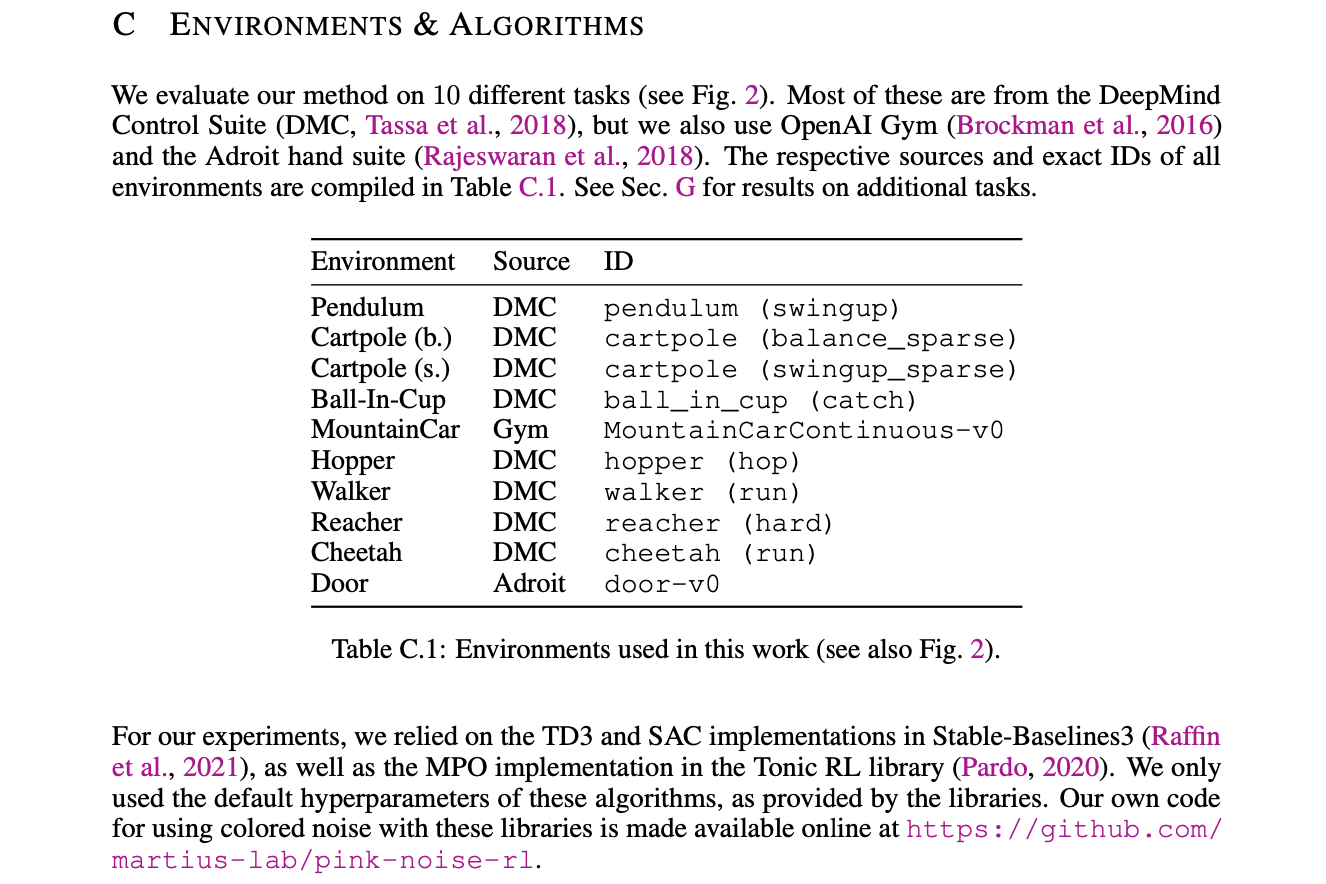

## Examples from conference paper

In [ ]:
"""Comparing pink action noise with the default noise on SAC."""

import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import SAC

from pink import PinkNoiseDist

# Reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

# Initialize environment
env = gym.make("MountainCarContinuous-v0")
action_dim = env.action_space.shape[-1]
seq_len = env._max_episode_steps
rng = np.random.default_rng(0)

# Initialize agents
model_default = SAC("MlpPolicy", env, seed=seed)
model_pink = SAC("MlpPolicy", env, seed=seed)

# Set action noise
model_pink.actor.action_dist = PinkNoiseDist(seq_len, action_dim, rng=rng)

# Train agents
model_default.learn(total_timesteps=10_000)
model_pink.learn(total_timesteps=10_000)

# Evaluate learned policies
N = 100
for name, model in zip(["Default noise\n-------------", "Pink noise\n----------"], [model_default, model_pink]):
    solved = 0
    for i in range(N):
        obs, _ = env.reset() # gymnasium возвращает 5 значений из env.step() вместо 4
        done = False
        while not done:
            # obs, r, done, _ = env.step(model.predict(obs, deterministic=True)[0]) - аналогично
            action, _ = model.predict(obs, deterministic=True)
            obs, r, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if r > 0:
                solved += 1
                break

    print(name)
    print(f"Solved: {solved/N * 100:.0f}%\n")


# - Output of this program -
# Default noise
# -------------
# Solved: 0%
#
# Pink noise
# ----------
# Solved: 100%

Default noise
-------------
Solved: 0%

Pink noise
----------
Solved: 100%



# My experiments with 3 environment:
- "MountainCarContinuous-v0"
- "Pendulum-v1"
- "CartPole-v1"

In [ ]:
# pip install stable_baselines3
# pip install shimmy
# import numpy as np
# pip install gymnasium[classic_control]
# pip install stable-baselines3==2.3.2
# pip install box2d
# pip install gymnasium[box2d]

In [ ]:
import gymnasium as gym
import numpy as np
import torch
# from stable_baselines3 import SAC
from tqdm import tqdm
import matplotlib.pyplot as plt

# from pink import PinkNoiseDist

np.bool8 = np.bool

# Reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

env_names = [
    "MountainCarContinuous-v0",
    # "Pendulum-v1",
    # "LunarLanderContinuous-v3",
    # "BipedalWalker-v3"
]

betas = [0.1, 0.2, 0.35, 0.5, 0.75, 1.0, 1.5, 2.0]
timesteps = 10_000
eval_interval = 1000
N_eval = 100

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Функции шума
class WhiteNoise:
    def __init__(self, action_dim):
        self.action_dim = action_dim
    def sample(self):
        return np.random.normal(size=self.action_dim)

class OUNoise:
    def __init__(self, action_dim, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.theta = theta
        self.sigma = sigma
        self.state = np.zeros(action_dim)
    def reset(self):
        self.state = np.zeros(self.action_dim)
    def sample(self):
        dx = self.theta * (-self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state

In [ ]:
def train_with_noise(env, noise_type, beta=None):
    print(f"Training with noise={noise_type}{'' if beta is None else f' β={beta}'}")

    action_dim = env.action_space.shape[-1]
    seq_len = env._max_episode_steps

    #- model = SAC("MlpPolicy", env, seed=seed, verbose=0)
    print(device)
    model = SAC("MlpPolicy", env, seed=seed, verbose=0, device=device)

    # Pink Noise: подменяем action_dist в actor
    if noise_type == 'Pink':
        model.actor.action_dist = PinkNoiseDist(seq_len, action_dim, rng=np.random.default_rng(seed))

    # WN или OU
    elif noise_type == 'WN':
        noise_obj = WhiteNoise(action_dim)
    elif noise_type == 'OU':
        noise_obj = OUNoise(action_dim)
        noise_obj.reset()

    results = []

    for t in tqdm(range(0, timesteps, eval_interval),
                  desc=f"Training {noise_type}{'' if beta is None else f' β={beta}'}"):

        model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)

        rewards = []
        for _ in range(N_eval):
            obs, _ = env.reset()
            done = False
            ep_reward = 0
            while not done:
                action, _ = model.predict(obs, deterministic=True)

                if noise_type == 'WN' or noise_type == 'OU':
                    noise = noise_obj.sample()
                    if torch.is_tensor(noise):
                        noise = noise.cpu().numpy()
                    action = np.clip(action + noise, -1, 1)

                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                ep_reward += reward

            rewards.append(ep_reward)

        mean_r = np.mean(rewards)
        results.append((t + eval_interval, mean_r))
        tqdm.write(f"Step {t + eval_interval}: mean reward = {mean_r:.2f}")

    return results


обучаю модель на 10_000 шагах и после каждой 1000 смотрю какая будет средняя награда на 100 запусках

In [ ]:
all_results = {}

for env_name in env_names:
    print(f"\n=== Environment: {env_name} ===")
    env = gym.make(env_name)

    all_results[env_name] = {}

    # WN
    torch.cuda.empty_cache()
    all_results[env_name]['WN'] = train_with_noise(env, 'WN')

    # OU
    torch.cuda.empty_cache()
    all_results[env_name]['OU'] = train_with_noise(env, 'OU')

    # Pink Noise - β
    for beta in betas:
        torch.cuda.empty_cache()
        key = f"Pink_{beta}"
        all_results[env_name][key] = train_with_noise(env, 'Pink', beta=beta)

    env.close()


=== Environment: BipedalWalker-v3 ===
Training with noise=WN
cuda


Training WN:  10%|█         | 1/10 [00:01<00:14,  1.59s/it]

Step 1: mean reward = -115.01


Training WN:  30%|███       | 3/10 [00:03<00:05,  1.19it/s]

Step 2: mean reward = -215.60
Step 3: mean reward = -105.19


Training WN:  50%|█████     | 5/10 [00:05<00:04,  1.16it/s]

Step 4: mean reward = -113.57
Step 5: mean reward = -101.51


Training WN:  70%|███████   | 7/10 [00:05<00:01,  2.07it/s]

Step 6: mean reward = -109.45
Step 7: mean reward = -102.18


Training WN: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Step 8: mean reward = -105.94
Step 9: mean reward = -104.88
Step 10: mean reward = -113.56
Training with noise=OU
cuda


Step 1: mean reward = -107.05


Training OU:  20%|██        | 2/10 [00:00<00:01,  7.22it/s]

Step 2: mean reward = -120.31
Step 3: mean reward = -108.97


Training OU:  40%|████      | 4/10 [00:00<00:00,  8.49it/s]

Step 4: mean reward = -115.76
Step 5: mean reward = -113.47


Training OU:  70%|███████   | 7/10 [00:00<00:00,  7.49it/s]

Step 6: mean reward = -101.97
Step 7: mean reward = -99.22


Training OU: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]

Step 8: mean reward = -98.56
Step 9: mean reward = -100.63
Step 10: mean reward = -109.56
Training with noise=Pink β=0.1
cuda



Training Pink β=0.1:  10%|█         | 1/10 [00:01<00:14,  1.57s/it]

Step 1: mean reward = -3.33


Training Pink β=0.1:  20%|██        | 2/10 [00:03<00:12,  1.57s/it]

Step 2: mean reward = -3.13


Training Pink β=0.1:  30%|███       | 3/10 [00:04<00:11,  1.59s/it]

Step 3: mean reward = -3.48


Training Pink β=0.1:  40%|████      | 4/10 [00:06<00:10,  1.74s/it]

Step 4: mean reward = -4.35


Training Pink β=0.1:  50%|█████     | 5/10 [00:08<00:08,  1.68s/it]

Step 5: mean reward = -4.63


Training Pink β=0.1:  60%|██████    | 6/10 [00:10<00:07,  1.80s/it]

Step 6: mean reward = -4.55


Training Pink β=0.1:  70%|███████   | 7/10 [00:12<00:05,  1.78s/it]

Step 7: mean reward = -4.26


Training Pink β=0.1:  80%|████████  | 8/10 [00:13<00:03,  1.72s/it]

Step 8: mean reward = -3.34


Training Pink β=0.1:  90%|█████████ | 9/10 [00:15<00:01,  1.73s/it]

Step 9: mean reward = -3.64


Training Pink β=0.1: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Step 10: mean reward = -3.31
Training with noise=Pink β=0.2
cuda


Training Pink β=0.2:  10%|█         | 1/10 [00:01<00:14,  1.62s/it]

Step 1: mean reward = -4.42


Training Pink β=0.2:  20%|██        | 2/10 [00:03<00:13,  1.65s/it]

Step 2: mean reward = -4.34


Training Pink β=0.2:  30%|███       | 3/10 [00:05<00:12,  1.80s/it]

Step 3: mean reward = -3.48


Training Pink β=0.2:  40%|████      | 4/10 [00:07<00:10,  1.80s/it]

Step 4: mean reward = -4.35


Training Pink β=0.2:  50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

Step 5: mean reward = -4.63


Training Pink β=0.2:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

Step 6: mean reward = -4.55


Training Pink β=0.2:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

Step 7: mean reward = -4.26


Training Pink β=0.2:  80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

Step 8: mean reward = -3.34


Training Pink β=0.2:  90%|█████████ | 9/10 [00:15<00:01,  1.63s/it]

Step 9: mean reward = -3.64


Training Pink β=0.2: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Step 10: mean reward = -3.31
Training with noise=Pink β=0.35
cuda


Training Pink β=0.35:  10%|█         | 1/10 [00:01<00:16,  1.82s/it]

Step 1: mean reward = -4.42


Training Pink β=0.35:  20%|██        | 2/10 [00:03<00:13,  1.69s/it]

Step 2: mean reward = -3.77


Training Pink β=0.35:  30%|███       | 3/10 [00:04<00:11,  1.63s/it]

Step 3: mean reward = -3.62


Training Pink β=0.35:  40%|████      | 4/10 [00:06<00:09,  1.63s/it]

Step 4: mean reward = -3.48


Training Pink β=0.35:  50%|█████     | 5/10 [00:08<00:08,  1.63s/it]

Step 5: mean reward = -4.54


Training Pink β=0.35:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

Step 6: mean reward = -2.53


Training Pink β=0.35:  70%|███████   | 7/10 [00:12<00:05,  1.91s/it]

Step 7: mean reward = -3.27


Training Pink β=0.35:  80%|████████  | 8/10 [00:14<00:03,  1.86s/it]

Step 8: mean reward = -3.29


Training Pink β=0.35:  90%|█████████ | 9/10 [00:15<00:01,  1.80s/it]

Step 9: mean reward = -2.96


Training Pink β=0.35: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Step 10: mean reward = -3.35
Training with noise=Pink β=0.5
cuda


Training Pink β=0.5:  10%|█         | 1/10 [00:01<00:14,  1.57s/it]

Step 1: mean reward = -3.33


Training Pink β=0.5:  20%|██        | 2/10 [00:03<00:12,  1.58s/it]

Step 2: mean reward = -3.30


Training Pink β=0.5:  30%|███       | 3/10 [00:04<00:10,  1.57s/it]

Step 3: mean reward = -3.62


Training Pink β=0.5:  40%|████      | 4/10 [00:06<00:10,  1.70s/it]

Step 4: mean reward = -3.48


Training Pink β=0.5:  50%|█████     | 5/10 [00:08<00:08,  1.78s/it]

Step 5: mean reward = -4.54


Training Pink β=0.5:  60%|██████    | 6/10 [00:10<00:06,  1.71s/it]

Step 6: mean reward = -2.53


Training Pink β=0.5:  70%|███████   | 7/10 [00:11<00:05,  1.67s/it]

Step 7: mean reward = -3.27


Training Pink β=0.5:  80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

Step 8: mean reward = -3.29


Training Pink β=0.5:  90%|█████████ | 9/10 [00:14<00:01,  1.63s/it]

Step 9: mean reward = -2.96


Training Pink β=0.5: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Step 10: mean reward = -3.35
Training with noise=Pink β=0.75
cuda


Training Pink β=0.75:  10%|█         | 1/10 [00:01<00:15,  1.77s/it]

Step 1: mean reward = -3.33


Training Pink β=0.75:  20%|██        | 2/10 [00:03<00:14,  1.85s/it]

Step 2: mean reward = -3.13


Training Pink β=0.75:  30%|███       | 3/10 [00:05<00:12,  1.73s/it]

Step 3: mean reward = -3.19


Training Pink β=0.75:  40%|████      | 4/10 [00:06<00:10,  1.68s/it]

Step 4: mean reward = -4.35


Training Pink β=0.75:  50%|█████     | 5/10 [00:08<00:08,  1.65s/it]

Step 5: mean reward = -4.63


Training Pink β=0.75:  60%|██████    | 6/10 [00:10<00:06,  1.65s/it]

Step 6: mean reward = -4.55


Training Pink β=0.75:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it]

Step 7: mean reward = -4.26


Training Pink β=0.75:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

Step 8: mean reward = -3.34


Training Pink β=0.75:  90%|█████████ | 9/10 [00:15<00:01,  1.77s/it]

Step 9: mean reward = -3.64


Training Pink β=0.75: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Step 10: mean reward = -3.31
Training with noise=Pink β=1
cuda


Training Pink β=1:  10%|█         | 1/10 [00:01<00:14,  1.60s/it]

Step 1: mean reward = -4.42


Training Pink β=1:  20%|██        | 2/10 [00:03<00:12,  1.61s/it]

Step 2: mean reward = -4.34


Training Pink β=1:  30%|███       | 3/10 [00:04<00:11,  1.61s/it]

Step 3: mean reward = -3.48


Training Pink β=1:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]

Step 4: mean reward = -4.35


Training Pink β=1:  50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

Step 5: mean reward = -4.63


Training Pink β=1:  60%|██████    | 6/10 [00:10<00:07,  1.78s/it]

Step 6: mean reward = -4.55


Training Pink β=1:  70%|███████   | 7/10 [00:11<00:05,  1.73s/it]

Step 7: mean reward = -4.26


Training Pink β=1:  80%|████████  | 8/10 [00:13<00:03,  1.68s/it]

Step 8: mean reward = -3.34


Training Pink β=1:  90%|█████████ | 9/10 [00:14<00:01,  1.65s/it]

Step 9: mean reward = -3.64


Training Pink β=1: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Step 10: mean reward = -3.31
Training with noise=Pink β=1.5
cuda


Training Pink β=1.5:  10%|█         | 1/10 [00:01<00:14,  1.62s/it]

Step 1: mean reward = -4.42


Training Pink β=1.5:  20%|██        | 2/10 [00:03<00:12,  1.62s/it]

Step 2: mean reward = -3.77


Training Pink β=1.5:  30%|███       | 3/10 [00:05<00:12,  1.84s/it]

Step 3: mean reward = -2.36


Training Pink β=1.5:  40%|████      | 4/10 [00:07<00:10,  1.78s/it]

Step 4: mean reward = -3.48


Training Pink β=1.5:  50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

Step 5: mean reward = -4.54


Training Pink β=1.5:  60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

Step 6: mean reward = -2.53


Training Pink β=1.5:  70%|███████   | 7/10 [00:11<00:04,  1.64s/it]

Step 7: mean reward = -3.27


Training Pink β=1.5:  80%|████████  | 8/10 [00:13<00:03,  1.62s/it]

Step 8: mean reward = -3.29


Training Pink β=1.5:  90%|█████████ | 9/10 [00:14<00:01,  1.61s/it]

Step 9: mean reward = -2.96


Training Pink β=1.5: 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


Step 10: mean reward = -3.35
Training with noise=Pink β=2
cuda


Training Pink β=2:  10%|█         | 1/10 [00:01<00:16,  1.80s/it]

Step 1: mean reward = -3.33


Training Pink β=2:  20%|██        | 2/10 [00:03<00:13,  1.67s/it]

Step 2: mean reward = -3.30


Training Pink β=2:  30%|███       | 3/10 [00:04<00:11,  1.62s/it]

Step 3: mean reward = -3.62


Training Pink β=2:  40%|████      | 4/10 [00:06<00:09,  1.62s/it]

Step 4: mean reward = -3.48


Training Pink β=2:  50%|█████     | 5/10 [00:08<00:08,  1.61s/it]

Step 5: mean reward = -4.54


Training Pink β=2:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]

Step 6: mean reward = -2.53


Training Pink β=2:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

Step 7: mean reward = -3.27


Training Pink β=2:  80%|████████  | 8/10 [00:13<00:03,  1.73s/it]

Step 8: mean reward = -3.29


Training Pink β=2:  90%|█████████ | 9/10 [00:15<00:01,  1.70s/it]

Step 9: mean reward = -2.96


Training Pink β=2: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

Step 10: mean reward = -3.35


In [ ]:
import json

# путь к файлу
filename = "all_results.json"

# открыть и считать
with open(filename, "r", encoding="utf-8") as f:
    all_results = json.load(f)

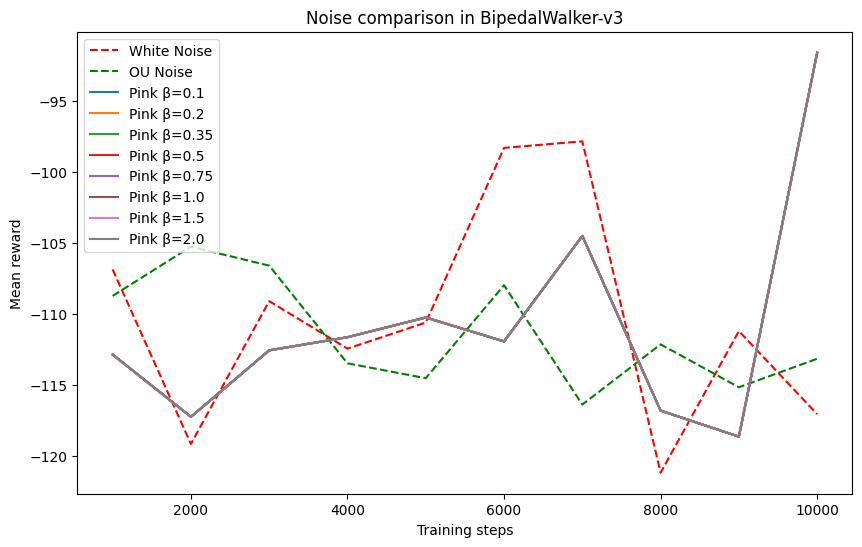

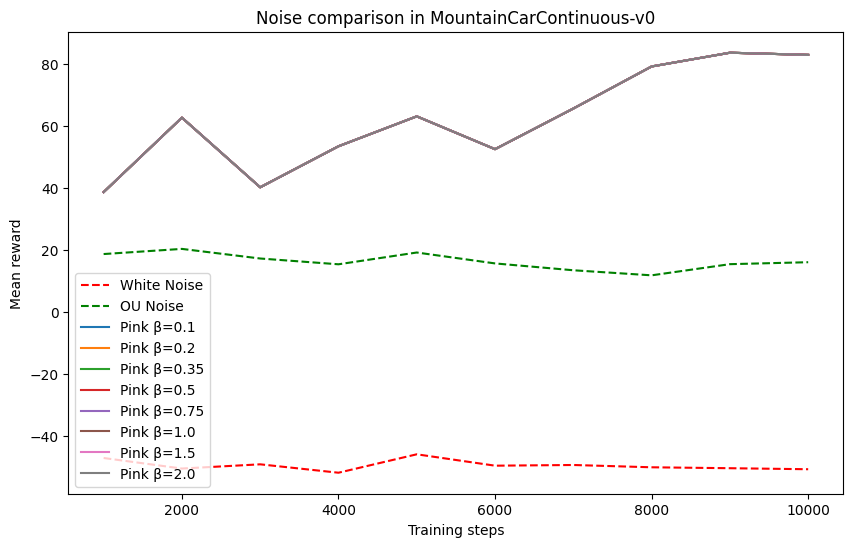

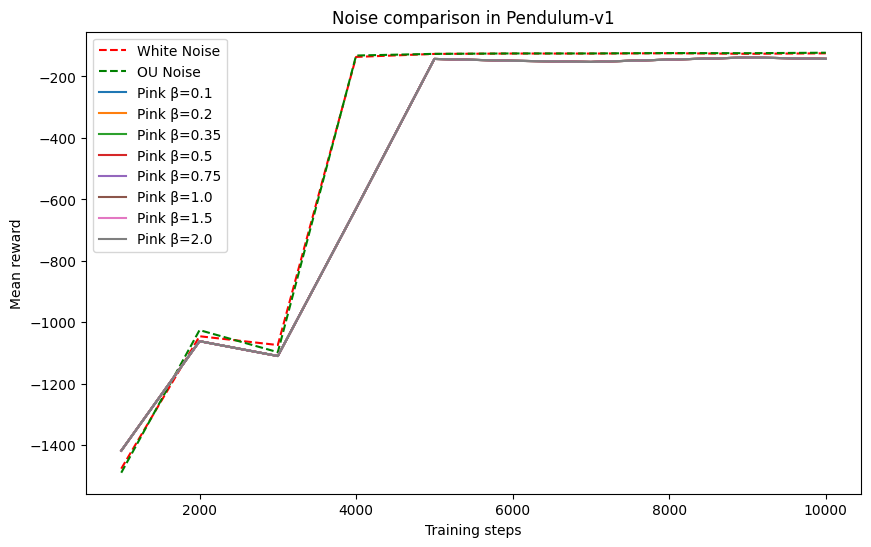

In [ ]:
# Построение графиков
for env_name in all_results.keys():
    plt.figure(figsize=(10,6))
    # WN
    steps, rewards_list = zip(*all_results[env_name]['WN'])
    plt.plot(steps, rewards_list, 'r--', label='White Noise')
    # OU
    steps, rewards_list = zip(*all_results[env_name]['OU'])
    plt.plot(steps, rewards_list, 'g--', label='OU Noise')
    # Pink
    for beta in betas:
        key = f"Pink_{beta}"
        steps, rewards_list = zip(*all_results[env_name][key])
        plt.plot(steps, rewards_list, label=f'Pink β={beta}')
    plt.title(f"Noise comparison in {env_name}")
    plt.xlabel("Training steps")
    plt.ylabel("Mean reward")
    plt.legend()
    plt.show()

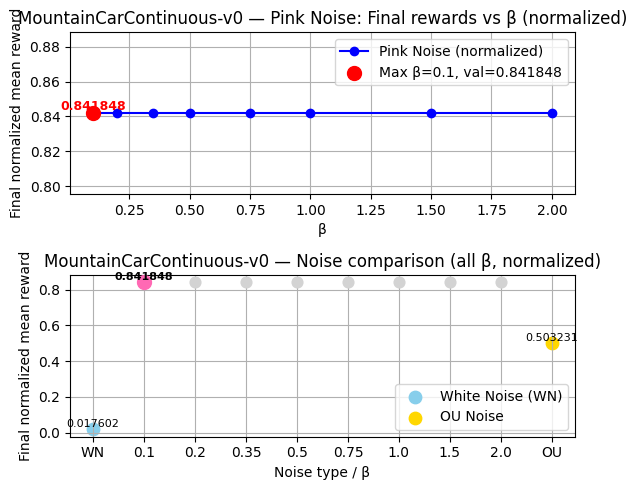

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_envs = len(env_names)
fig, axes = plt.subplots(nrows=num_envs*2, ncols=1, figsize=(6, 5*num_envs))

for i, env_name in enumerate(env_names):
    # Собираем все награды среды для нормализации
    all_rewards = []
    for key in all_results[env_name]:
        _, rewards_list = zip(*all_results[env_name][key])
        all_rewards.extend(rewards_list)
    min_r, max_r = min(all_rewards), max(all_rewards)
    normalize = lambda vals: [(r - min_r) / (max_r - min_r + 1e-8) for r in vals]

    # === Верхний график: Pink β ===
    ax_top = axes[2*i] if num_envs > 1 else axes[0]
    pink_final = []
    for beta in betas:
        key = f"Pink_{beta}"
        rewards = [r for _, r in all_results[env_name][key]]
        pink_final.append(np.mean(normalize(rewards)))

    # Находим индекс максимума
    max_idx = np.argmax(pink_final)
    max_beta = betas[max_idx]
    max_val = pink_final[max_idx]

    # Отрисовка всех точек
    ax_top.plot(betas, pink_final, 'bo-', label='Pink Noise (normalized)')
    # Подсветка максимальной
    ax_top.scatter(max_beta, max_val, color='red', s=100, zorder=5, label=f'Max β={max_beta}, val={max_val:.6f}')
    ax_top.text(max_beta, max_val, f'{max_val:.6f}', color='red', ha='center', va='bottom', fontsize=9, weight='bold')

    ax_top.set_xlabel('β')
    ax_top.set_ylabel('Final normalized mean reward')
    ax_top.set_title(f'{env_name} — Pink Noise: Final rewards vs β (normalized)')
    ax_top.grid(True)
    ax_top.legend()

    # === Нижний график: WN → Pink (все β) → OU ===
    ax_bottom = axes[2*i+1] if num_envs > 1 else axes[1]
    wn_rewards = normalize([r for _, r in all_results[env_name]['WN']])
    ou_rewards = normalize([r for _, r in all_results[env_name]['OU']])
    wn_final = np.mean(wn_rewards)
    ou_final = np.mean(ou_rewards)

    # Pink β средние
    pink_means = []
    for beta in betas:
        key = f"Pink_{beta}"
        rewards = [r for _, r in all_results[env_name][key]]
        pink_means.append(np.mean(normalize(rewards)))

    # Определяем β с наибольшим значением
    best_beta_idx = np.argmax(pink_means)
    best_beta = betas[best_beta_idx]
    best_val = pink_means[best_beta_idx]

    # WN и OU
    ax_bottom.scatter(-1, wn_final, color='skyblue', s=80, label='White Noise (WN)')
    ax_bottom.text(-1, wn_final, f'{wn_final:.6f}', ha='center', va='bottom', fontsize=8, color='black')

    ax_bottom.scatter(len(betas), ou_final, color='gold', s=80, label='OU Noise')
    ax_bottom.text(len(betas), ou_final, f'{ou_final:.6f}', ha='center', va='bottom', fontsize=8, color='black')

    # Все β (Pink)
    for j, beta in enumerate(betas):
        val = pink_means[j]
        color = 'hotpink' if beta == best_beta else 'lightgray'
        size = 100 if beta == best_beta else 60
        ax_bottom.scatter(j, val, color=color, s=size, zorder=3)
        # Подпись только у лучшего β
        if beta == best_beta:
            ax_bottom.text(j, val, f'{val:.6f}', ha='center', va='bottom', fontsize=8, color='black', weight='bold')

    ax_bottom.set_xticks([-1] + list(range(len(betas))) + [len(betas)])
    ax_bottom.set_xticklabels(['WN'] + [f'{b}' for b in betas] + ['OU'])
    ax_bottom.set_xlabel('Noise type / β')
    ax_bottom.set_ylabel('Final normalized mean reward')
    ax_bottom.set_title(f'{env_name} — Noise comparison (all β, normalized)')
    ax_bottom.grid(True)
    ax_bottom.legend()

# 🔹 Больше расстояние между графиками
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()
